# Pan-Tompkins - Detección del complejo QRS

El primer paso en muchos procesamientos de ECG es encontrar los complejos QRS. El algoritmo de Pan-Tompkins es una serie de pasos de preprocesamiento y un algoritmo de detección para encontrar estos complejos. Podemos verlo en acción a continuación.

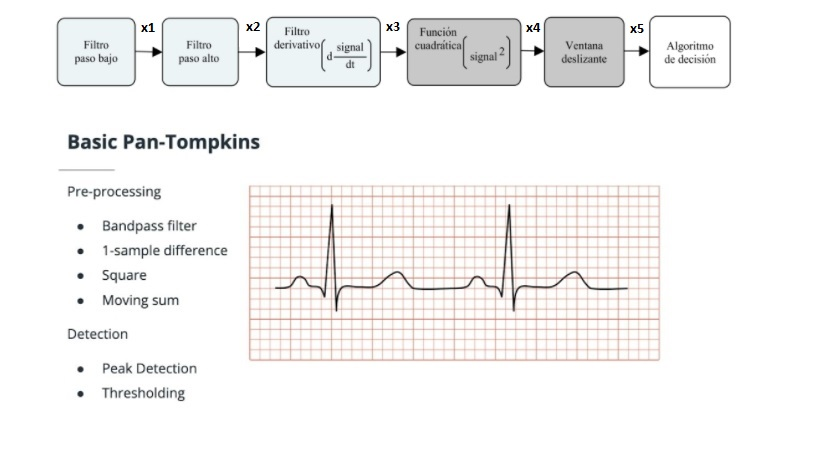

In [1]:
from IPython.display import Image
import pandas as pd
Image(filename='procedimiento_pan_and_tompkins.jpg',width=800, height=400)

# Librerias utilizadas:

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import scipy.signal as signal
import pathlib
import scipy.signal as signal
import scipy.io
import pandas as pd

# Carga de datos:

In [53]:
example = 'ECG.tsv'

unfiltered_ecg_dat = np.loadtxt(example) 
unfiltered_ecg = unfiltered_ecg_dat[:, 1]
unfiltered_ecg = unfiltered_ecg[0:3000]

fs = 250

# Métodos:

El algoritmo de Pan and Tompkins trabaja con la siguiente secuencia de métodos:

## 1. Filtro Pasa Banda:

En primer lugar, los componentes de alta frecuencia se eliminan mediante un filtro paso bajo. La entrada es x y la señal de salida es x1
Su función de transferencia viene dada por: 

$ H(z) =  \frac{(1-z^{-6})^{2}} {(1-z^{-1})^{2}} \\ $

Luego añadimos un filtro de paso alto con una función de transferencia 

$ H(z) = \frac{(-1-32z^{-16}+z^{-32})} {(1-z^{-1})} \\ $

La señal obtenida después de pasar x1 por este filtro es x2

## 2. Filtro derivativo:
La señal x2 es diferenciada en tiempo discreto en base a la función de transferencia: 

$ H(z) = \frac{(-z^{-2}-2z^{-1}+2z^{1}+z^{2})}{8T} $ 

para obtener $ x_3$

## 3. Funcion cuadratica:

Este paso simplemente eleva al cuadrado cada término como $y[nt] = x[nt]^{2} $ y devuelve la señal $ x_4 $

## 4. Ventana deslizante (Moving Window Average):
Se toma una media de ventana móvil con un tamaño de ventana de N como se ha definido anteriormente.
$ y[nt] = \frac {\sum_{k=0}^{(N-1)} x[nT - kT]} {N} $

## 5. Thresholds (algoritmos de decision):

### Señal de ruido:
Consideraremos que el ruido es la parte que se ha eliminado después del filtro paso banda. Para ello definimos el ruido como $x_n = \frac {x - x_2}{32*36}$ donde 32 y 36 son las ganancias de los filtros aplicados. También se intenta eliminar los valores atípicos de ser necesario.

### Picos y Medias:
La variable $peaki$ denotará el valor máximo actual de la señal $x_5$ y
$spki$ denotará el pico estimado de la señal $x_5$ <br> y $npki$ denotará el pico estimado del ruido de la señal $x_5$ <br>  

### Actualización:
Después de cada iteracion: 
- El valor de $spki = 0,125*peaki + 0,875*spki$ <br>
- El valor de $npki = 0,125*peaki + 0,875*npki$

### Thresholds:
Los valores de los umbrales se pueden encontrar basándose en la fórmula: 
- $TH1 = NPKI + 0,25(SPKI - NPKI)$
- $TH2 = 0.5 * TH1$

De este modo se pueden detectar los picos.

In [54]:
def panPeakDetect(detection, fs):    

    min_distance = int(0.25*fs)

    signal_peaks = [0]
    noise_peaks = []

    SPKI = 0.0
    NPKI = 0.0

    threshold_I1 = 0.0
    threshold_I2 = 0.0

    RR_missed = 0
    index = 0
    indexes = []

    missed_peaks = []
    peaks = []

    for i in range(len(detection)):

        if i>0 and i<len(detection)-1:
            if detection[i-1]<detection[i] and detection[i+1]<detection[i]:
                peak = i
                peaks.append(i)

                # Periodo refractario:

                if detection[peak]>threshold_I1 and (peak-signal_peaks[-1])>0.3*fs:
                        
                    signal_peaks.append(peak)
                    indexes.append(index)
                    SPKI = 0.125*detection[signal_peaks[-1]] + 0.875*SPKI
                    if RR_missed!=0:
                        if signal_peaks[-1]-signal_peaks[-2]>RR_missed:
                            missed_section_peaks = peaks[indexes[-2]+1:indexes[-1]]
                            missed_section_peaks2 = []
                            for missed_peak in missed_section_peaks:
                                if missed_peak-signal_peaks[-2]>min_distance and signal_peaks[-1]-missed_peak>min_distance and detection[missed_peak]>threshold_I2:
                                    missed_section_peaks2.append(missed_peak)

                            if len(missed_section_peaks2)>0:           
                                missed_peak = missed_section_peaks2[np.argmax(detection[missed_section_peaks2])]
                                missed_peaks.append(missed_peak)
                                signal_peaks.append(signal_peaks[-1])
                                signal_peaks[-2] = missed_peak   

                else:
                    noise_peaks.append(peak)
                    NPKI = 0.125*detection[noise_peaks[-1]] + 0.875*NPKI

                threshold_I1 = NPKI + 0.25*(SPKI-NPKI)
                threshold_I2 = 0.5*threshold_I1

                if len(signal_peaks)>8:
                    RR = np.diff(signal_peaks[-9:])
                    RR_ave = int(np.mean(RR))
                    RR_missed = int(1.66*RR_ave)

                index = index+1      
    
    signal_peaks.pop(0)

    return signal_peaks

In [55]:
#Fast implementation of moving window average with numpy's function 
def MWA(input_array, window_size):
    
    ret = np.cumsum(input_array, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    
    for i in range(1,window_size):
        ret[i-1] = ret[i-1] / i
    ret[window_size - 1:]  = ret[window_size - 1:] / window_size
    
    return ret

In [56]:
def pan_tompkins_detector(unfiltered_ecg):
        """
        Jiapu Pan and Willis J. Tompkins.
        A Real-Time QRS Detection Algorithm. 
        In: IEEE Transactions on Biomedical Engineering 
        BME-32.3 (1985), pp. 230–236.
        """
        MWA_name='cumulative'
        f1 = 5/fs
        f2 = 15/fs
       #diseño del filtro

        b, a = signal.butter(1, [f1*2, f2*2], btype='bandpass')

        # Filtrado propiamente dicho
        filtered_ecg = signal.lfilter(b, a, unfiltered_ecg)        
    
        # Derivador
        diff = np.diff(filtered_ecg) 
    
        # Funcion cuadratica: 
        squared = diff*diff

        N = int(0.12*fs)
        
        # Ventana deslizante (Moving Window Average):
        
        mwa = MWA(squared, N)
        mwa[:int(0.2*fs)] = 0

        mwa_peaks = panPeakDetect(mwa, fs)

        return mwa_peaks

In [57]:
r_peaks = pan_tompkins_detector(unfiltered_ecg)

In [58]:
r_peaks

[115,
 316,
 514,
 712,
 864,
 1036,
 1219,
 1384,
 1571,
 1731,
 1895,
 2101,
 2331,
 2493,
 2672,
 2833,
 2991]

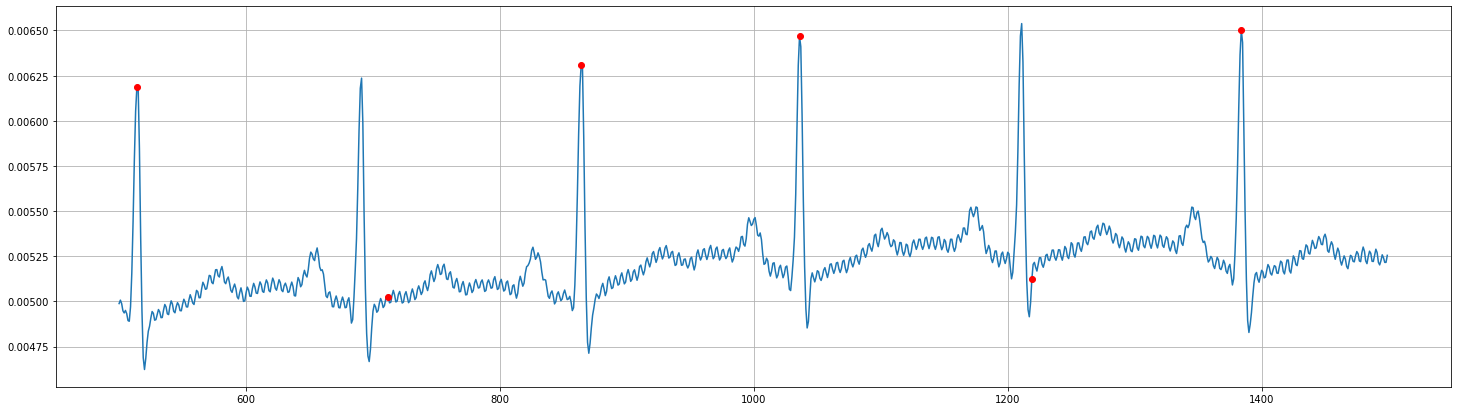

In [60]:
%matplotlib inline

min = 500
max = 1500

x= unfiltered_ecg
peak = r_peaks 
fig,ax = plt.subplots(1,1,figsize=(25,7))
ser = pd.Series(x[min:max],index=np.arange(min,max,1))
ser.plot(kind="line",grid=True,ax=ax)
filtered = list(filter(lambda peak: ((peak >min) & (peak < max)), peak))
plt.plot(filtered,ser.loc[filtered].values, 'ro')
plt.show()